In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import scipy
import seaborn as sns
import sklearn
import pysindy as ps
from sklearn.linear_model import Lasso
from tools import get_positive_contributions, compute_entropy, print_equations
from data_func import plot_clustered_kuramoto, generate_kuramoto_cluster_data_sin_cos

pipline操作流程：

1.生成数据：a 单起始点时间序列；b 多起始点时间序列

可选步骤：时间序列降采样

2.选择合适的library做观测

3.选择合适的optimizer做拟合：a 离散的迭代方程；b 连续的微分方程

4.计算score，多步预测效果看一下

5.提取系数矩阵，进行svd分解，得到奇异值谱和左奇异向量

6.观察奇异值谱截断，计算因果涌现程度，绘制多尺度contribution，计算EC

7.根据奇异向量和谱截断，输出粗粒化函数表达式

8.绘制宏观演化的时间序列，给出宏观动力学方程

可选的分析案例：

1.SIR：原始的SIR动力学；带观测噪音的四维微观数据

2.kuramoto模型

3.洛伦兹动力学

4.耦合Rulkov映射

# 数据生成

In [2]:
N=12
n_clusters=2  # 团数
K_intra=5
K_inter=0.1
noise=0
dt=0.01

In [22]:
# 多时间序列采样
T=5
batch = 1000
t_list = []
x_data = []
for seed in range(batch):
    x_train, theta_hist, t_train, K_matrix = generate_kuramoto_cluster_data_sin_cos(
        N=N, n_clusters=n_clusters, K_intra=K_intra, K_inter=K_inter, dt=dt, T=T, noise=noise, random_seed1=0, random_seed2=seed
    )
    x_data.append(x_train)
    t_list.append(t_train)

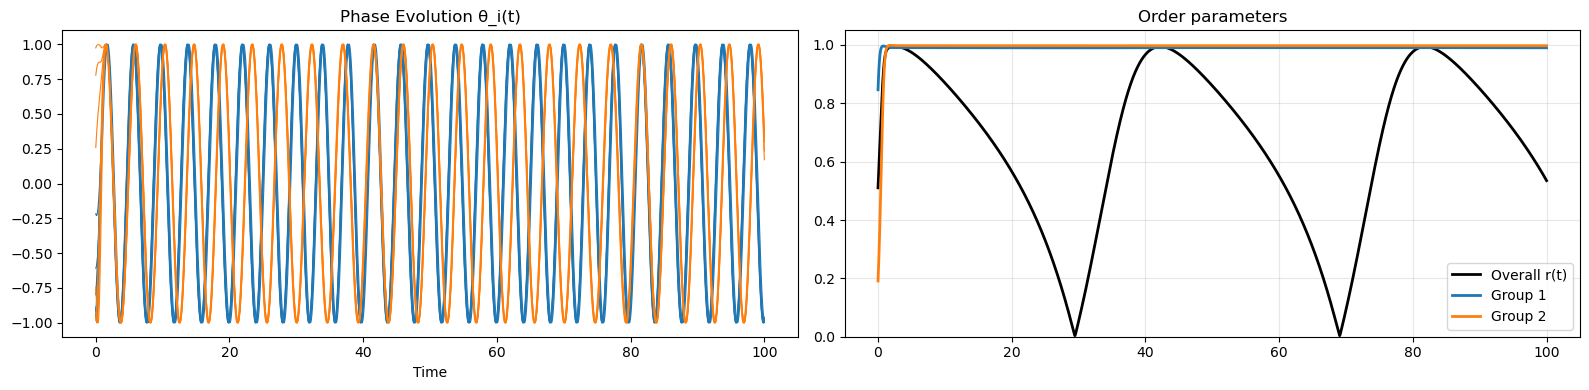

In [3]:
# 单时间序列采样
x_train, theta_hist, t_train, K_matrix = plot_clustered_kuramoto(
    N=N,          # 振子数
    n_clusters=n_clusters,  # 团数
    K_intra=K_intra,   # 团内耦合
    K_inter=K_inter,   # 团间耦合
    noise=noise,
    T=100,
    random_seed1=0, random_seed2=0,
    dt=dt
)

x_data = x_train


# 选择library

In [4]:
# 候选的观测函数
ide = ps.IdentityLibrary()
fourier = ps.FourierLibrary(n_frequencies=1)
ode_lib = ps.PolynomialLibrary(degree=1,include_bias=True)
library_functions = [
    lambda x: x,
    lambda x: np.sin(x),
    lambda x: np.cos(x),
]
custom_library = ps.CustomLibrary(library_functions=library_functions)

# 选定观测函数
library = ide + fourier

# 进行lift
library.fit(x_data)
x_data_lift = library.transform(x_data)
names = library.get_feature_names()

# 单时间序列
print(x_data_lift.shape)
# 多时间序列
#print(x_data_lift[0].shape)
# 检查观测函数变量名
print(names)

(10000, 72)
['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'sin(1 x0)', 'cos(1 x0)', 'sin(1 x1)', 'cos(1 x1)', 'sin(1 x2)', 'cos(1 x2)', 'sin(1 x3)', 'cos(1 x3)', 'sin(1 x4)', 'cos(1 x4)', 'sin(1 x5)', 'cos(1 x5)', 'sin(1 x6)', 'cos(1 x6)', 'sin(1 x7)', 'cos(1 x7)', 'sin(1 x8)', 'cos(1 x8)', 'sin(1 x9)', 'cos(1 x9)', 'sin(1 x10)', 'cos(1 x10)', 'sin(1 x11)', 'cos(1 x11)', 'sin(1 x12)', 'cos(1 x12)', 'sin(1 x13)', 'cos(1 x13)', 'sin(1 x14)', 'cos(1 x14)', 'sin(1 x15)', 'cos(1 x15)', 'sin(1 x16)', 'cos(1 x16)', 'sin(1 x17)', 'cos(1 x17)', 'sin(1 x18)', 'cos(1 x18)', 'sin(1 x19)', 'cos(1 x19)', 'sin(1 x20)', 'cos(1 x20)', 'sin(1 x21)', 'cos(1 x21)', 'sin(1 x22)', 'cos(1 x22)', 'sin(1 x23)', 'cos(1 x23)']


# 进行拟合

In [5]:
# 离散的迭代方程 or 连续的微分方程
discrete_time=False

# 候选拟合器
sr3_optimizer = ps.SR3(reg_weight_lam=0.2, regularizer="l1")
lasso_optimizer = Lasso(alpha=0.01, max_iter=2000, fit_intercept=False)

optimizer = lasso_optimizer

# 进行拟合
model = ps.SINDy(feature_library=ide, optimizer=optimizer, discrete_time=discrete_time)
model.fit(x_data_lift, t=dt, feature_names=names)
model.print()

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.489e+00, tolerance: 1.229e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.474e+00, tolerance: 1.224e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

(x0)' = -1.434 x12 + -0.034 x13 + -0.011 x14 + -0.072 x15
(x1)' = -0.790 x16 + -0.773 x17
(x2)' = -0.452 x12 + -0.779 x13 + -0.067 x14 + -0.216 x16 + -0.038 x17
(x3)' = -0.028 x12 + -0.007 x13 + -1.516 x15
(x4)' = 0.005 x8 + -0.069 x12 + -0.042 x15 + -1.446 x16
(x5)' = 0.074 x4 + -0.212 x16 + -1.315 x17
(x6)' = 0.006 x1 + -0.003 x17 + -1.385 x18 + -0.023 x23
(x7)' = 0.006 x1 + 0.005 x5 + -1.391 x20
(x8)' = 0.010 x4 + 0.001 x5 + -1.390 x20
(x9)' = 0.011 x3 + -0.028 x18 + -1.381 x21
(x10)' = 0.010 x4 + -0.540 x19 + -0.523 x20 + -0.148 x22 + -0.183 x23
(x11)' = 0.004 x1 + -0.002 x17 + -1.406 x23
(x12)' = 1.093 x0 + 0.010 x2 + 0.447 x4
(x13)' = 1.545 x1
(x14)' = 0.579 x0 + 0.679 x1 + 0.270 x2 + 0.023 x5
(x15)' = 1.419 x3 + 0.132 x4
(x16)' = 1.565 x4 + 0.012 x22
(x17)' = 0.045 x1 + 1.499 x5
(x18)' = 1.405 x6 + 0.002 x9 + 0.012 x13
(x19)' = 0.788 x7 + 0.593 x9 + 0.001 x16 + 0.016 x17 + 0.027 x18
(x20)' = 0.659 x7 + 0.719 x9 + 0.016 x16 + 0.006 x17 + 0.032 x21
(x21)' = 1.410 x9 + 0.014 x13
(x

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.412e+00, tolerance: 2.165e-01
  model = cd_fast.enet_coordinate_descent(


In [6]:
# 计算score
model.score(x_data_lift, t=dt)

0.8867065514653683

# 多步预测

/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_59643/2380654559.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


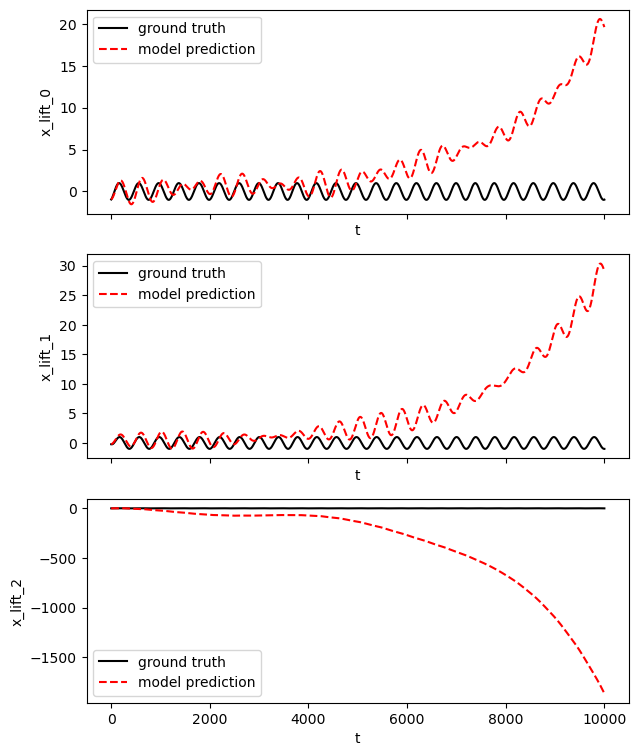

In [8]:
# 单时间序列
init_data = x_data_lift[0,:]
# 多时间序列
#init_data = x_data_lift[0][0,:]

if discrete_time:
    X_data_predicted = model.simulate(init_data,len(t_train)-1)
else:
    X_data_predicted = model.simulate(init_data,t_train) 

# 只看部分维度的多步预测
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(7, 9))
for i in range(3):
    axs[i].plot(x_data_lift[:, i], "k", label="ground truth")
    axs[i].plot(X_data_predicted[:, i], "r--", label="model prediction")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=r"x_lift_{}".format(i))
fig.show()

# svd分解

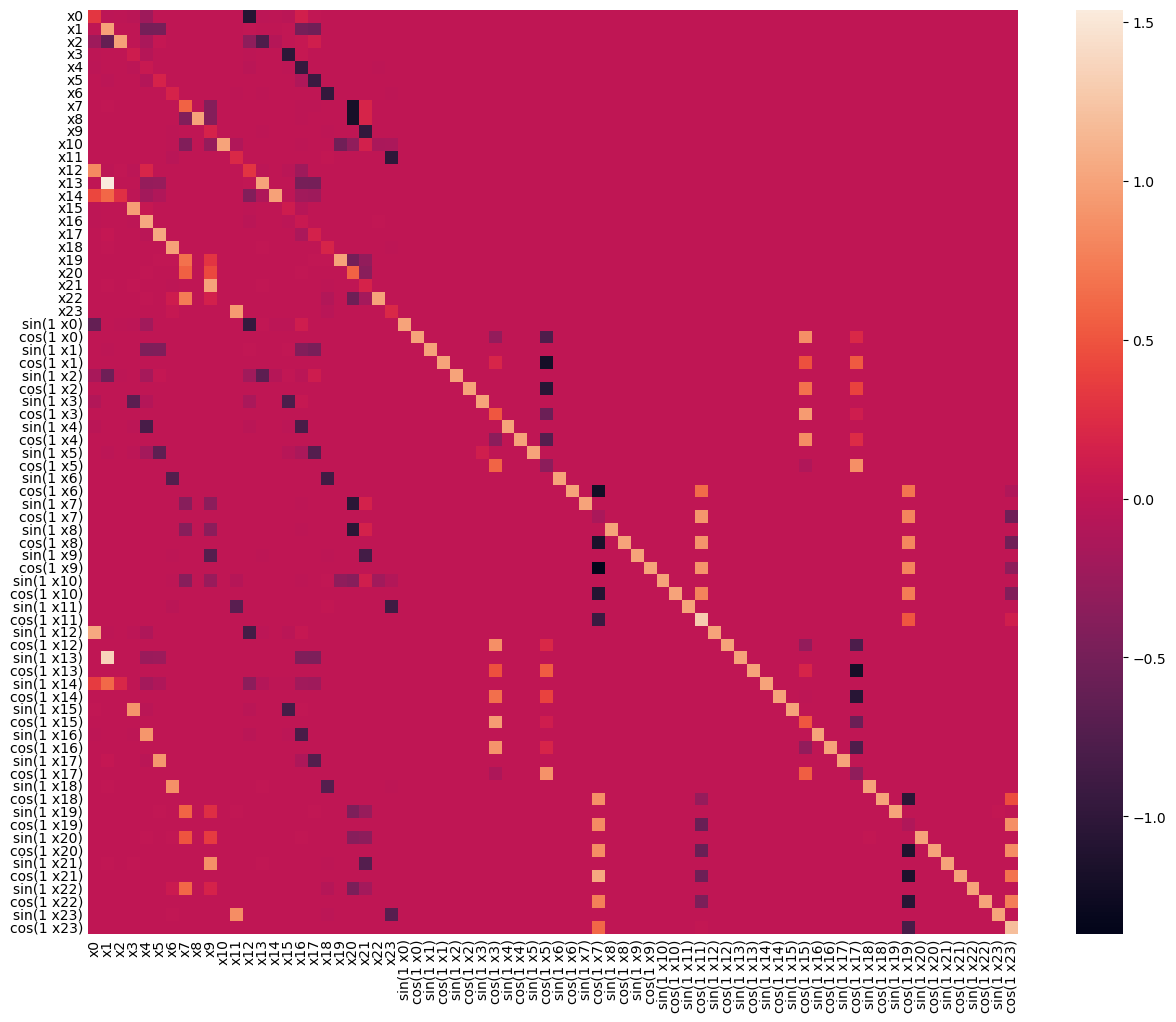

In [10]:
# 提取和处理系数矩阵
A = model.coefficients()
if discrete_time==False:
    A = scipy.linalg.expm(A)

# 只设置参数，不自动显示全部
plt.figure(figsize=(15, 12)) # 把画布搞大一点
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(A, xticklabels=names, yticklabels=names)
# 旋转横轴标签，避免重叠
plt.xticks(rotation=90)  # 旋转90度
plt.yticks(rotation=0)   # 纵轴保持水平
plt.show()

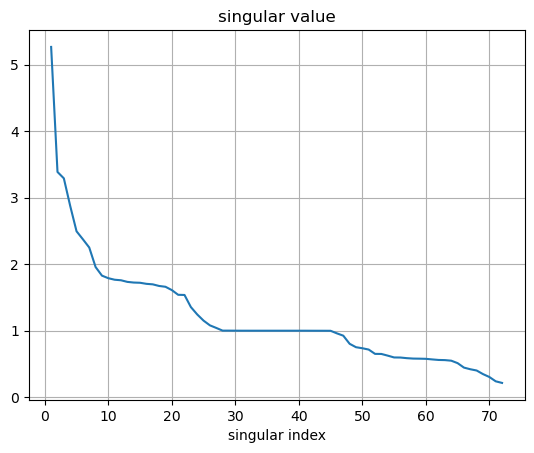

[5.26618327 3.38670376 3.29069694 2.87633161 2.49452208 2.3744747 ]


In [11]:
# SVD
U,S,V = np.linalg.svd(A)
plt.figure()
plt.plot(range(1,len(S)+1), S)
plt.grid(True)
plt.xlabel('singular index')
plt.title('singular value')
plt.show()
print(S[:6])

In [12]:
# 选取截断
rank = 3
S_macro = S[:rank]
delt_gamma = sum(S_macro) / rank - sum(S) / len(S)
print(delt_gamma)

2.773125390760581


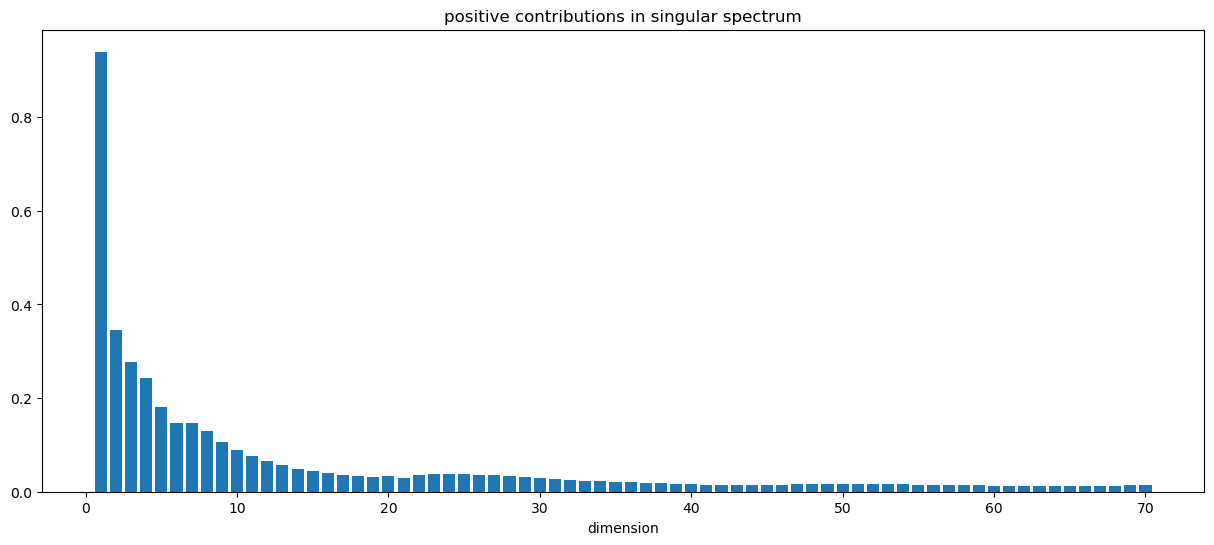

In [14]:
# 多尺度因果力分布
diff = get_positive_contributions(S)
plt.figure(figsize=(15, 6))
plt.bar(range(1,len(diff)+1), diff) 
plt.xlabel('dimension')
plt.title('positive contributions in singular spectrum')
plt.show()

In [15]:
# 计算EC
print(compute_entropy(diff))

4.828950254663243


# 输出粗粒化表达式

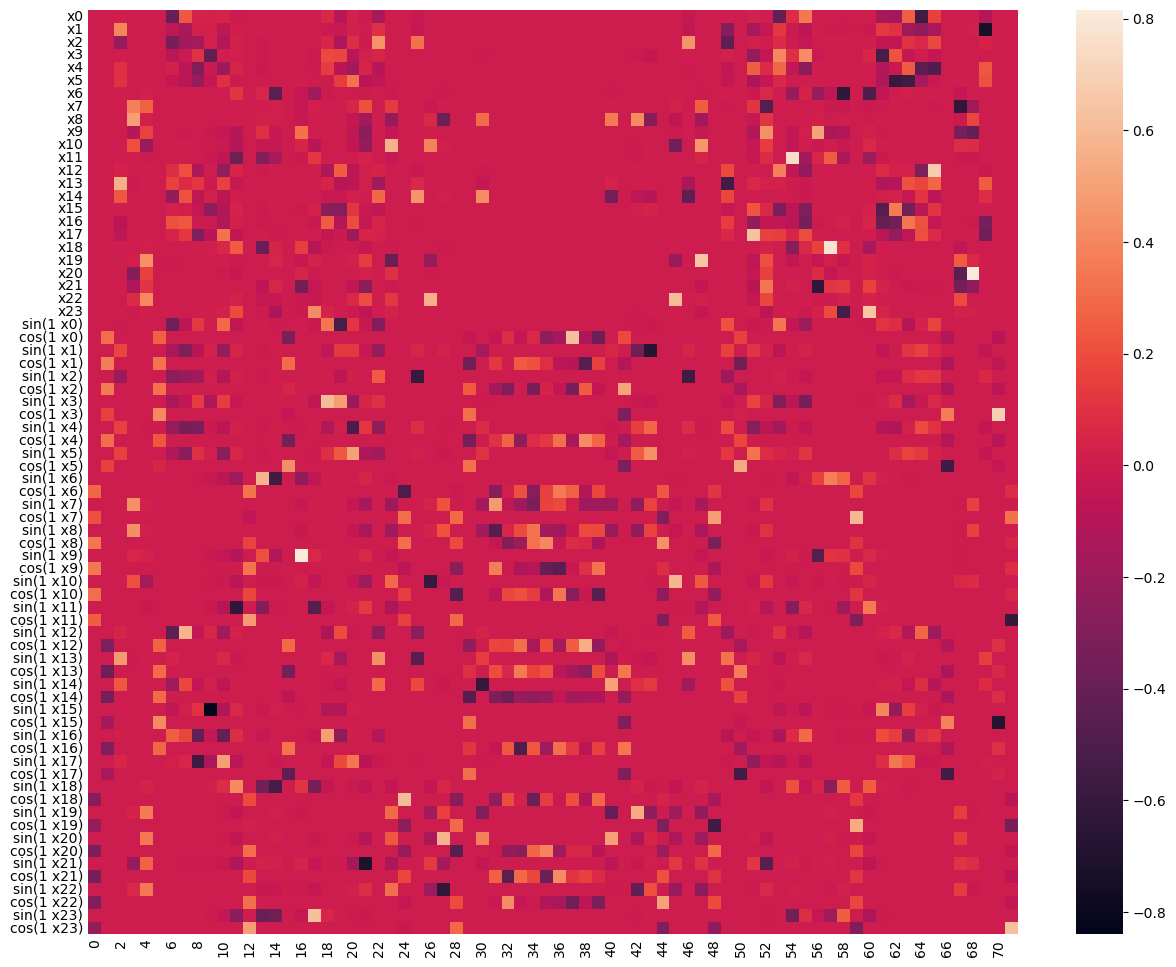

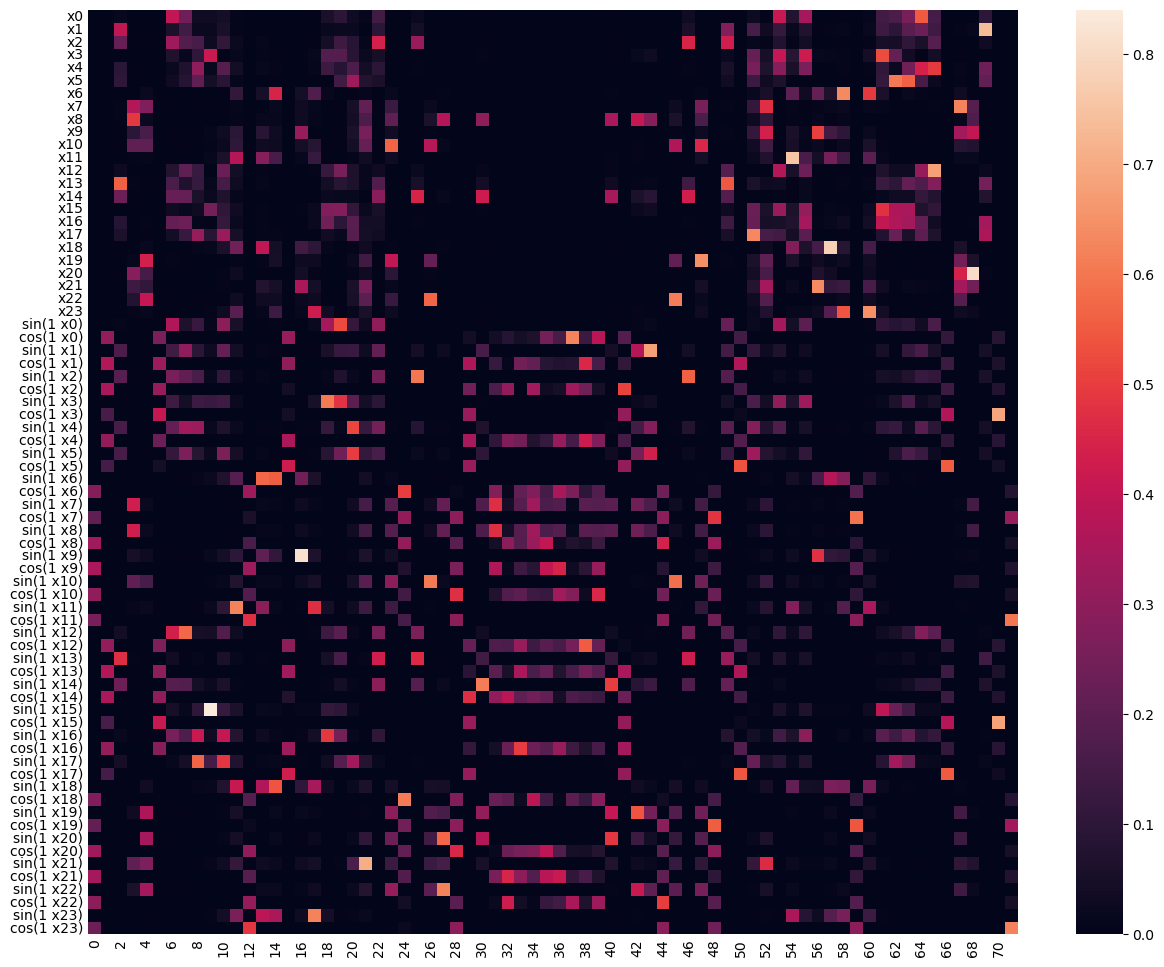

In [16]:
# 绘制奇异向量
U_abs = np.abs(U)

plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(U, yticklabels=names)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()


plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(U_abs, yticklabels=names)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show() 

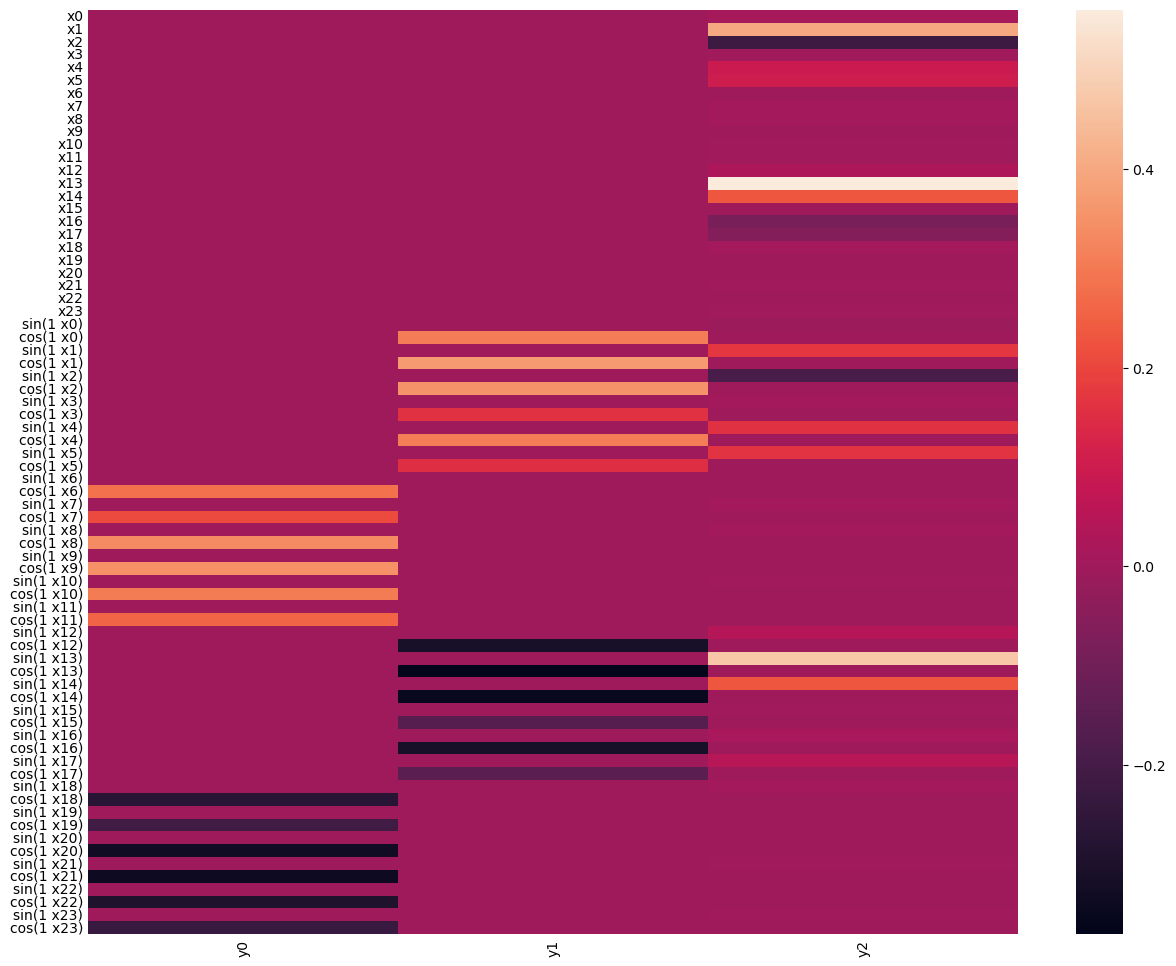

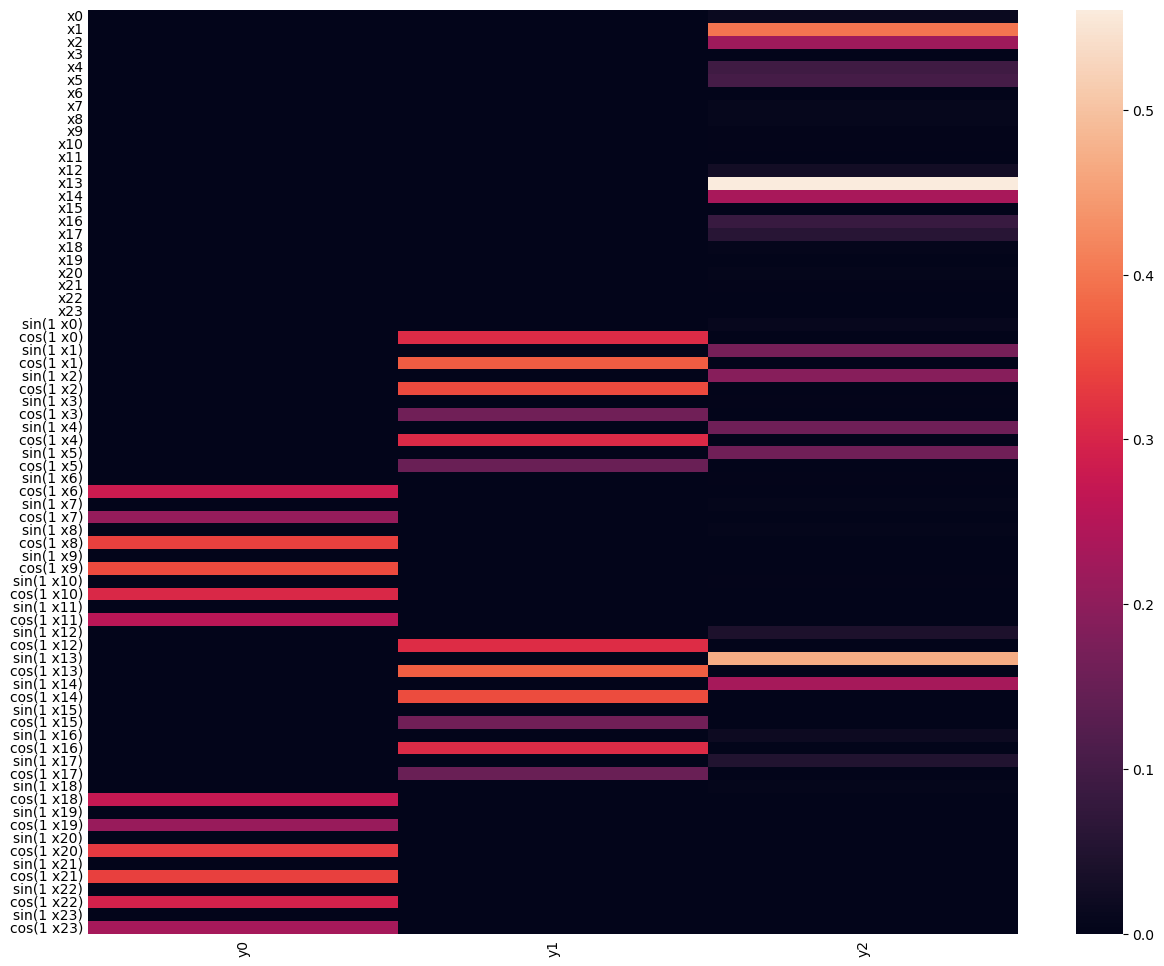

In [17]:
# 粗粒化函数系数
macro_name = [f'y{i}' for i in range(rank)]
coarse_grain_coff = U[:,:rank]

plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(coarse_grain_coff, yticklabels=names, xticklabels=macro_name)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()


plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(np.abs(coarse_grain_coff), yticklabels=names, xticklabels=macro_name)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()

In [49]:
# 输出粗粒化函数表达式
print_equations(coarse_grain_coff, names, macro_name)

y0 = 0.2821 * cos(1 x6) + 0.2086 * cos(1 x7) + 0.3379 * cos(1 x8) + 0.3485 * cos(1 x9) + 0.3046 * cos(1 x10) + 0.2567 * cos(1 x11) - 0.2718 * cos(1 x18) - 0.2136 * cos(1 x19) - 0.3285 * cos(1 x20) - 0.3388 * cos(1 x21) - 0.2945 * cos(1 x22) - 0.2318 * cos(1 x23)
------------------------------
y1 = 0.3093 * cos(1 x0) + 0.3681 * cos(1 x1) + 0.3498 * cos(1 x2) + 0.1603 * cos(1 x3) + 0.3077 * cos(1 x4) + 0.1525 * cos(1 x5) - 0.3109 * cos(1 x12) - 0.3702 * cos(1 x13) - 0.3519 * cos(1 x14) - 0.1623 * cos(1 x15) - 0.3096 * cos(1 x16) - 0.1518 * cos(1 x17)
------------------------------
y2 = 0.0133 * x0 + 0.3969 * x1 - 0.2203 * x2 + 0.0011 * x3 + 0.0930 * x4 + 0.1021 * x5 + 0.0003 * x6 + 0.0071 * x7 + 0.0072 * x8 - 0.0034 * x9 + 0.0039 * x10 + 0.0009 * x11 + 0.0266 * x12 + 0.5604 * x13 + 0.2321 * x14 + 0.0005 * x15 - 0.0837 * x16 - 0.0604 * x17 + 0.0051 * x18 - 0.0017 * x19 - 0.0055 * x20 + 0.0024 * x21 - 0.0008 * x22 + 0.0018 * x23 - 0.0099 * sin(1 x0) + 0.1691 * sin(1 x1) - 0.1915 * sin(1 x2

# 描述宏观演化

/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_52232/580934310.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


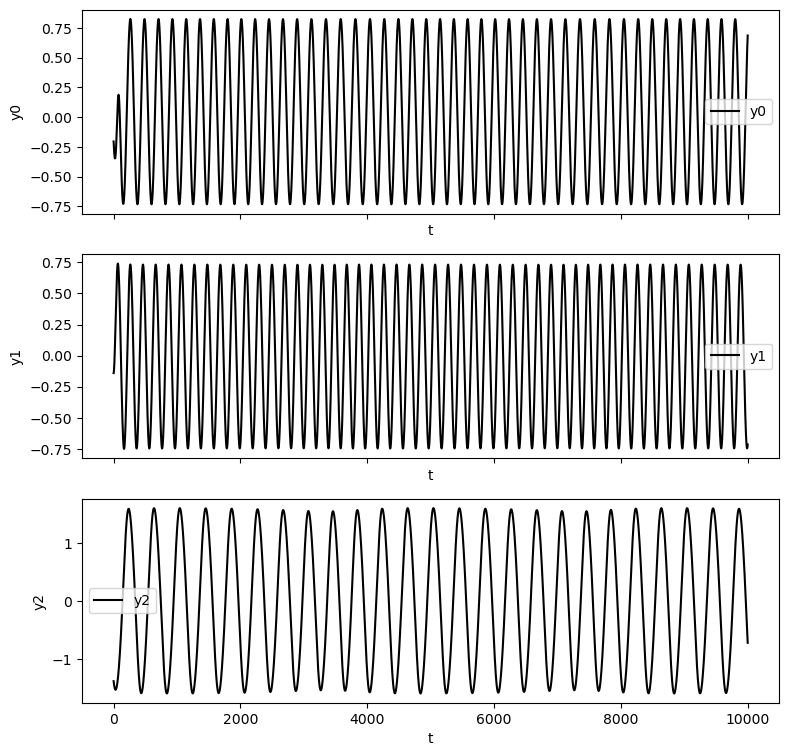

In [51]:
macro_data = x_data_lift @ coarse_grain_coff
macro_dim = macro_data.shape[1]

fig, axs = plt.subplots(macro_dim, 1, sharex=True, figsize=(int(3*macro_dim), 9))
for i in range(macro_dim):
    axs[i].plot(macro_data[:, i], "k", label=f"y{i}")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=f"y{i}")
fig.show()

In [55]:
# 给出宏观动力学方程
A_macro = coarse_grain_coff.T @ A @ coarse_grain_coff
macro_name_k = [i+'[k]' for i in macro_name]
macro_name_next = [i+'[k+1]' for i in macro_name]
print_equations(A_macro, macro_name_k, macro_name_next)

y0[k+1] = 0.5219 * y0[k]
------------------------------
y1[k+1] = -0.0575 * y1[k]
------------------------------
y2[k+1] = 1.9095 * y2[k]
------------------------------
